## Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from math import log
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import neighbors, metrics

from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

In [209]:
print(tf.__version__)

2.4.1


## Import data

Source: <a href="http://tennis-data.co.uk/" target="_blank">http://tennis-data.co.uk/</a>

In [210]:
df_global=pd.DataFrame()
for i in range(2002,2021):
    
    url="http://tennis-data.co.uk/%d/%d.xlsx" %(i,i)
    df=pd.read_excel(url)
    df_global= pd.concat([df_global,df],ignore_index=True)

Create a datframe with Atp matches since 2002

In [211]:
print(df_global.shape)
list_col=df_global.columns #save columns names
df_global.head()

(50249, 54)


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Arazi H.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Carlsen K.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Chela J.I.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Draper S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean Data

We can notice that depending the year, Betting Broker are not the same. So it's better to use the Min/Max and Average of betting odds. 

In [212]:
#Fill NaN values
df_global['MaxW']=df_global['MaxW'].fillna(round(df_global[['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']].max(axis=1),2))
df_global['MaxL']=df_global['MaxL'].fillna(round(df_global[['B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']].max(axis=1),2))
df_global['AvgW']=df_global['AvgW'].fillna(round(df_global[['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']].mean(axis=1),2))
df_global['AvgL']=df_global['AvgL'].fillna(round(df_global[['B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']].mean(axis=1),2))

In [213]:
# drop useless datas
df_global=df_global[df_global['MaxW'].notna() & df_global['MaxL'].notna()] # select rows where betting odds are present
df_global=df_global.drop(df_global[df_global["Comment"]!="Completed"].index) #keep only completed matches
df_global=df_global.drop(['Comment','Date','ATP','Best of'],axis=1) # drop useless columns
df_global=df_global.drop(['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW','B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL'],axis=1)
df_global=df_global.drop(['W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','WPts','LPts'],axis=1)
df_global=df_global.drop(df_global[(df_global["WRank"]=='NR') |  (df_global["LRank"]=='NR')].index) # drop matches with No ranked players
df_global=df_global.dropna()
df_global["LRank"] = df_global.LRank.astype(float)# no more 'NR' players so we can convert into float

In [214]:
#df_global.loc[df_global["Loser"].str.contains("Zayed")==True]


In [215]:
def checkName(Name):
    if '..' in Name:
        Name=Name.replace('..','.')
    else:
        Name=Name
        
    if '. ' in Name:
        Name=Name.replace('. ','.')
    else:
        Name=Name    
        
    length=len(Name)
    if Name[length-1]!='.':
        Name=Name+'.'
    else:
        Name=Name
    return Name

In [216]:
#Keep same syntax for player Name in order to have an unique ID for each player
df_global["Winner"]=df_global["Winner"].apply(lambda x: checkName(x))
df_global["Loser"]=df_global["Loser"].apply(lambda x: checkName(x))

In [217]:
#Some Series have been renamed over years
df_global['Series'].replace({"International Gold":"ATP500","Masters Cup":"ATP Finals","Masters":"ATP Finals"},inplace =True)

In [218]:
df_global['Series'].value_counts()

ATP250           12505
Grand Slam        9052
International     8715
ATP500            7221
Masters 1000      6133
ATP Finals        4142
Name: Series, dtype: int64

In [219]:
#Check if NaN values left
print(df_global.isna().sum())
print(df_global.shape)


Location      0
Tournament    0
Series        0
Court         0
Surface       0
Round         0
Winner        0
Loser         0
WRank         0
LRank         0
MaxW          0
MaxL          0
AvgW          0
AvgL          0
dtype: int64
(47768, 14)


## Preprocessing data

Columns label encoding

In [220]:
def Labelizer(column):
    label=sorted(column.unique())
    dictionnary = { val : idx for idx,val in enumerate(label) }
    colLab=column.map(dictionnary)
    return colLab
    

In [221]:
df_test=df_global.copy()
df_global=df_global.apply(lambda x: Labelizer(x) if x.dtype==object else x,axis=0)

df_global.head()

,Location,Tournament,Series,Court,Surface,Round,Winner,Loser,WRank,LRank,MaxW,MaxL,AvgW,AvgL
0,2,0,4,1,3,0,22,604,25.0,46.0,1.60,2.20,1.55,2.17
6,2,0,4,1,3,0,320,362,9.0,309.0,1.15,4.25,1.15,4.25
10,2,0,4,1,3,0,480,998,57.0,10.0,3.80,1.36,3.09,1.30
11,2,0,4,1,3,0,483,1017,80.0,93.0,1.50,2.55,1.47,2.35
13,2,0,4,1,3,0,589,136,104.0,53.0,1.50,2.40,1.50,2.27


In [222]:
#Rename columns: Winner -> Player1 & Loser -> Player2
df_global.rename(columns={'Winner':'Player1','Loser':'Player2','WRank':'P1Rank','LRank':'P2Rank','MaxW':'MaxP1','MaxL':'MaxP2','AvgW':'AvgP1','AvgL':'AvgP2'}, inplace=True)
#Create the column for the label prediction: Player1 Win
df_global['P1Winner']=1 

In the actual format all winners are Player 1, it will be a problem for the model.
So for random rows, Players 1 and Player 2 datas are switched

In [223]:
mask=df_global.sample(frac=.5).index
df_global.loc[mask,['Player1','Player2','P1Rank','P2Rank','MaxP1','MaxP2','AvgP1','AvgP2']] = df_global.loc[mask,['Player2','Player1','P2Rank','P1Rank','MaxP2','MaxP1','AvgP2','AvgP1']].values
df_global.loc[mask,['P1Winner']]=0

In [224]:
df_global.head()

,Location,Tournament,Series,Court,Surface,Round,Player1,Player2,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,P1Winner
0,2,0,4,1,3,0,604.0,22.0,46.0,25.0,2.20,1.60,2.17,1.55,0
6,2,0,4,1,3,0,362.0,320.0,309.0,9.0,4.25,1.15,4.25,1.15,0
10,2,0,4,1,3,0,998.0,480.0,10.0,57.0,1.36,3.80,1.30,3.09,0
11,2,0,4,1,3,0,483.0,1017.0,80.0,93.0,1.50,2.55,1.47,2.35,1
13,2,0,4,1,3,0,136.0,589.0,53.0,104.0,2.40,1.50,2.27,1.50,0


We can create a function for the cleaning and preprocessing process:

In [225]:
def CleanData(dataframe):
    
    df_clean=dataframe

    df_clean['MaxW']=df_clean['MaxW'].fillna(round(df_clean[['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']].max(axis=1),2))
    df_clean['MaxL']=df_clean['MaxL'].fillna(round(df_clean[['B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']].max(axis=1),2))
    df_clean['AvgW']=df_clean['AvgW'].fillna(round(df_clean[['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']].mean(axis=1),2))
    df_clean['AvgL']=df_clean['AvgL'].fillna(round(df_clean[['B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']].mean(axis=1),2))

    # drop useless datas
    df_clean=df_clean[df_clean['MaxW'].notna() & df_clean['MaxL'].notna()] # select rows where betting odds are present
    df_clean=df_clean.drop(df_clean[df_clean["Comment"]!="Completed"].index) #keep only completed matches
    df_clean=df_clean.drop(['Comment','Date','ATP','Best of'],axis=1) # drop useless columns
    df_clean=df_clean.drop(['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW','B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL'],axis=1)
    df_clean=df_clean.drop(['W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','WPts','LPts'],axis=1)
    df_clean=df_clean.drop(df_clean[(df_clean["WRank"]=='NR') |  (df_clean["LRank"]=='NR')].index) # drop matches with No ranked players
    df_clean=df_clean.dropna()
    df_clean["LRank"] = df_clean.LRank.astype(float)# no more 'NR' players so we can convert into float


    df_clean["Winner"]=df_clean["Winner"].apply(lambda x: checkName(x))
    df_clean["Loser"]=df_clean["Loser"].apply(lambda x: checkName(x))
    
    df_clean['Series'].replace({"International Gold":"ATP500","Masters Cup":"ATP Finals","Masters":"ATP Finals"},inplace =True)

    df_clean=df_clean.merge(df_try,left_on='Winner',right_on="Name", how='left',suffixes=['L','W']) #first merge for winner player
    df_clean=df_clean.merge(df_try,left_on='Loser',right_on="Name", how='left',suffixes=['W','L'])#second merge for loser player

    df_clean=df_clean.drop(['NameW','NameL',"Winner","Loser"],axis=1) # keep only the player ID
    df_clean=df_clean.dropna() # delete rows with NaN values
    df_clean=df_clean.drop_duplicates() #delete duplicated rows

    df_clean=df_clean.apply(lambda x: Labelizer(x) if x.dtype==object else x,axis=0) # Columns label encoding

    #Rename columns and randomisation process
    df_clean.rename(columns={'IdW':'IdP1','IdL':'IdP2','WRank':'P1Rank','LRank':'P2Rank','MaxW':'MaxP1','MaxL':'MaxP2','AvgW':'AvgP1','AvgL':'AvgP2','ScrapHeightW':'HeightP1','ScrapHeightL':'HeightP2','ScrapHandW':'HandP1','ScrapHandL':'HandP2'}, inplace=True)
    #Create the column for the label prediction: Player1 Win
    df_clean['P1Winner']=1 
    mask=df_clean.sample(frac=.5).index
    df_clean.loc[mask,['IdP1','IdP2','P1Rank','P2Rank','MaxP1','MaxP2','AvgP1','AvgP2','HeightP1','HeightP2','HandP1','HandP2']] = df_clean.loc[mask,['IdP2','IdP1','P2Rank','P1Rank','MaxP2','MaxP1','AvgP2','AvgP1','HeightP2','HeightP1','HandP2','HandP1']].values
    df_clean.loc[mask,['P1Winner']]=0
    
    return df_clean

Create a normalized dataframe

In [226]:
normalized_df=df_global.copy()
normalized_df.iloc[:,:-1]=df_global.apply(lambda x: (x-x.mean())/x.std() )

normalized_df.head()

,Location,Tournament,Series,Court,Surface,Round,Player1,Player2,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,P1Winner
0,-1.858634,-1.683901,0.959634,0.471629,0.862871,-0.719589,0.272380,-1.516767,-0.292839,-0.514919,-0.008951,-0.012206,-0.183920,-0.439966,0
6,-1.858634,-1.683901,0.959634,0.471629,0.862871,-0.719589,-0.473767,-0.605115,2.401071,-0.682819,0.001568,-0.014540,0.698333,-0.606222,0
10,-1.858634,-1.683901,0.959634,0.471629,0.862871,-0.719589,1.487182,-0.115637,-0.661587,-0.179119,-0.013262,-0.000797,-0.552940,0.200118,0
11,-1.858634,-1.683901,0.959634,0.471629,0.862871,-0.719589,-0.100693,1.527173,0.055423,0.198656,-0.012543,-0.007279,-0.480832,-0.107455,1
13,-1.858634,-1.683901,0.959634,0.471629,0.862871,-0.719589,-1.170582,0.217820,-0.221138,0.314088,-0.007925,-0.012725,-0.141504,-0.460748,0


In [227]:
df_global.isna().sum()

Location      0
Tournament    0
Series        0
Court         0
Surface       0
Round         0
Player1       0
Player2       0
P1Rank        0
P2Rank        0
MaxP1         0
MaxP2         0
AvgP1         0
AvgP2         0
P1Winner      0
dtype: int64

In [228]:
#correlation matrix
corrMatrix = normalized_df.corr()
print(corrMatrix)

            Location  Tournament    Series     Court   Surface     Round  \
Location    1.000000    0.086961  0.055139 -0.185694  0.062140 -0.017117   
Tournament  0.086961    1.000000  0.061485 -0.011004  0.137828 -0.019093   
Series      0.055139    0.061485  1.000000  0.127522 -0.014483 -0.048046   
Court      -0.185694   -0.011004  0.127522  1.000000 -0.162685 -0.057317   
Surface     0.062140    0.137828 -0.014483 -0.162685  1.000000  0.006152   
Round      -0.017117   -0.019093 -0.048046 -0.057317  0.006152  1.000000   
Player1     0.009453    0.001132  0.019127 -0.004304 -0.003738 -0.017757   
Player2     0.000817   -0.004601  0.015277 -0.008978 -0.004901 -0.009976   
P1Rank     -0.015947   -0.018496 -0.027453  0.020543 -0.032147 -0.195008   
P2Rank     -0.011103   -0.020861 -0.033943  0.021783 -0.037771 -0.198296   
MaxP1       0.002067    0.006528  0.002235  0.003036  0.004153 -0.003456   
MaxP2      -0.001048    0.006952  0.002403  0.003016 -0.000598 -0.003582   
AvgP1       

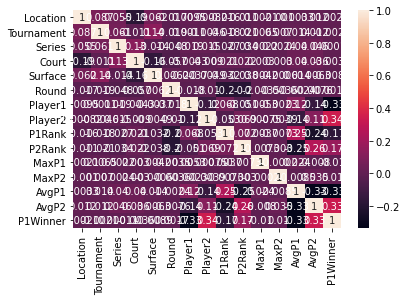

In [229]:
sn.heatmap(corrMatrix, annot=True)
plt.show() 

## Models

In [230]:

X=normalized_df.drop(["P1Winner"],axis=1)
y=normalized_df["P1Winner"]

#knn=neighbors.KNeighborsClassifier(n_neighbors=25,weights='uniform')
model = svm.SVC(gamma="auto",kernel='linear')

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train,y_train)

prediction=model.predict(X_test)

accuracy = metrics.classification_report(y_test,prediction,target_names=['Player1Lost','Player1Won'])

print("prediction",prediction)
print("accuracy: ",accuracy)

SVC(gamma='auto', kernel='linear')

prediction [1 0 1 ... 1 1 1]
accuracy:                precision    recall  f1-score   support

 Player1Lost       0.75      0.76      0.75      4798
  Player1Won       0.75      0.74      0.75      4756

    accuracy                           0.75      9554
   macro avg       0.75      0.75      0.75      9554
weighted avg       0.75      0.75      0.75      9554



In [231]:
from sklearn.metrics import f1_score
f1_score(y_test,prediction)

0.7463791098424781

## Try to improve F1-Score

We will try to improve dataset with new features

### Import players dataset

Source: <a href="https://www.kaggle.com/romanzdk/atp-players-overviews" target="_blank">https://www.kaggle.com/romanzdk/atp-players-overviews/</a>

In [232]:
df_players=pd.read_csv('player_overviews.csv')
df_players=df_players.drop(df_players.columns[4:17],axis=1)
df_players.columns=['AtpId','AtpName','FirstName','Name','height','handedness','backhand']
df_players.head()

,a002,ricardo-acuna,Ricardo,Acuna,175,Unnamed: 18,Unnamed: 19
0,a001,sadiq-abdullahi,Sadiq,Abdullahi,0.0,NaN,NaN
1,a005,nelson-aerts,Nelson,Aerts,188.0,NaN,NaN
2,a004,egan-adams,Egan,Adams,178.0,NaN,NaN
3,a006,ronald-agenor,Ronald,Agenor,180.0,NaN,NaN
4,a007,juan-aguilera,Juan,Aguilera,183.0,NaN,NaN


,AtpId,AtpName,FirstName,Name,height,handedness,backhand
0,a001,sadiq-abdullahi,Sadiq,Abdullahi,0.0,NaN,NaN
1,a005,nelson-aerts,Nelson,Aerts,188.0,NaN,NaN
2,a004,egan-adams,Egan,Adams,178.0,NaN,NaN
3,a006,ronald-agenor,Ronald,Agenor,180.0,NaN,NaN
4,a007,juan-aguilera,Juan,Aguilera,183.0,NaN,NaN


The dataset is not udpated and some current players are missing. The idea is to scrap datas from the https://www.atptour.com/ website.

### Scraping

We scrape datas for the 700 first players of the current ATP ranking 

In [233]:
#Player informations' are accessible through their atp overview webpage. 
#To get this page we need the name and the id given by the website.
#A first scrap on 'https://www.atptour.com/en/rankings/singles/ gives the url of the overview page
#Then for each player, we scrap First name and Last name in their overview webpage and create a dictionnary

def Scrap():
    AtpIdList=[]
    AtpNameList=[]
    FirstNameList=[]
    LastNameList=[]
    atpRank='https://www.atptour.com/en/rankings/singles/?rankDate=2020-9-14&countryCode=all&rankRange=0-700'
    req = Request(atpRank, headers={'User-Agent': ''})
    webpageAtp = urlopen(req).read()
    soup = BeautifulSoup(webpageAtp, 'html.parser')
    for i in range(0,700):
        url_overview='https://www.atptour.com' + soup.select('.player-cell a')[i]['href']
        AtpName=url_overview.split("/")[5]
        AtpId=url_overview.split("/")[6]
        
        req2 = Request(url_overview, headers={'User-Agent': 'Mozilla/5.0'})
        webpage_overview = urlopen(req2).read()
        soup2 = BeautifulSoup(webpage_overview, 'html.parser')
        try:
            FirstName = soup2.find( attrs={'class': 'first-name'}).get_text()
        except AttributeError:
            FirstName=np.nan
        
        try:
            Name = soup2.find( attrs={'class': 'last-name'}).get_text()
        except AttributeError:
            Name=np.nan
            
        AtpIdList.append(AtpId)
        AtpNameList.append(AtpName)
        FirstNameList.append(FirstName)
        LastNameList.append(Name)
        
        Dictionnary={'AtpId':AtpIdList,'AtpName':AtpNameList,'FirstName':FirstNameList,'Name':LastNameList,'height':np.nan,'handedness':np.nan,'backhand':np.nan}

    return Dictionnary

In [234]:
df_scrap=Scrap() #get a dictionnary with scraped datas
df_scrap=pd.DataFrame(df_scrap) #convert dictionnary into dataframe
df_total_players=pd.concat([df_players, df_scrap], ignore_index=True) # concat the scraping dataframe with the original one
df_total_players.drop_duplicates(subset ="AtpId",keep = "first", inplace = True) # KEEP UNIQUE VALUES
print(df_total_players.shape)

(11188, 7)


### Change Name syntax to be similar to global_dateset

For a future merge with the betting dataframe, we need to apply the same syntax to the Name column

In [235]:
def PlayerName(Name,FirstName):
    length= len(Name)
    if "-" in FirstName:
        FirstName=FirstName.split("-")
        player=Name+' '+FirstName[0][0]+'.'+FirstName[1][0]+'.'
    elif " " in FirstName:
        FirstName=FirstName.split()
        if len(FirstName)>1:
            player=Name+' '+FirstName[0][0]+'.'+FirstName[1][0]+'.'
        else:
            player=Name+' '+FirstName[0]+'.'
    elif Name[length-1]=='.':
        player=Name+FirstName[0]+'.'
        
    else:
        player=Name+' '+FirstName[0]+'.'
    return player.title()

In [236]:
df_total_players['Name']=df_total_players.apply(lambda x: PlayerName(x["Name"],x["FirstName"]), axis=1)
df_total_players=df_total_players.drop(["FirstName"],axis=1) #column not needed anymore
print(df_total_players['Name'].size)
df_total_players.head()

11188


,AtpId,AtpName,Name,height,handedness,backhand
0,a001,sadiq-abdullahi,Abdullahi S.,0.0,NaN,NaN
1,a005,nelson-aerts,Aerts N.,188.0,NaN,NaN
2,a004,egan-adams,Adams E.,178.0,NaN,NaN
3,a006,ronald-agenor,Agenor R.,180.0,NaN,NaN
4,a007,juan-aguilera,Aguilera J.,183.0,NaN,NaN


### Create a dataframe with only players present in the betting dataframe

In [237]:
df_selected_players=df_total_players.copy()
df_selected_players=df_selected_players[df_selected_players["Name"].isin(df_test['Winner'])| df_selected_players["Name"].isin(df_test['Loser'])] 

In [238]:
d=df_total_players[~df_total_players.Name.isin(df_selected_players.Name)]
print(d.shape)
d.head()

(9955, 6)


,AtpId,AtpName,Name,height,handedness,backhand
0,a001,sadiq-abdullahi,Abdullahi S.,0.0,NaN,NaN
1,a005,nelson-aerts,Aerts N.,188.0,NaN,NaN
2,a004,egan-adams,Adams E.,178.0,NaN,NaN
3,a006,ronald-agenor,Agenor R.,180.0,NaN,NaN
4,a007,juan-aguilera,Aguilera J.,183.0,NaN,NaN


132 players datas are still not find

In [239]:
print(df_selected_players.shape)

(1233, 6)


In [240]:
print(df_selected_players["height"].isna().sum())
print(df_selected_players["handedness"].isna().sum())
print(df_selected_players["backhand"].isna().sum())

277
577
577


Height, Handedness and Backhand are interesting criterias to analyse but we have too many 'Nan' values. Thanks to the AtId and AtpNAme we can scrap on the website https://www.atptour.com/ 

In [241]:
def scraping(atpId,atpName,height,handedness,backhand):
    url_atp = 'https://www.atptour.com/en/players/'+atpName+'/'+atpId+'/overview'
    req = Request(url_atp, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, 'html.parser')
    if ((height!=height) or (height==0.0)): #check NaN value or height equals to 0
        try:
            height = soup.find( attrs={'class': 'table-height-cm-wrapper'}).get_text()
            height= height.replace('(','').replace(')','').replace('cm','')
        except AttributeError:
            height=np.nan
    else:
        height=height

    if handedness!=handedness: #check NaN value
        try:
            plays= soup.find_all( attrs={'class':"table-value"})
            if len(plays)>=2:
                plays=plays[2].get_text()
                if len(plays)>1:
                    plays=plays.split(", ")
                    
                    handedness=plays[0].replace("\r","")
                    handedness=handedness.replace("\n","")
                    if backhand != backhand:
                        backhand=plays[1].rstrip()
                    else:
                        backhand=backhand    
                else:
                    if backhand != backhand:
                        backhand=np.nan
                    else:
                        backhand=backhand 
                    handedness=plays[0].replace("\r","")
                    handedness=handedness.replace("\n","")
            else:
                handedness=np.nan
                if backhand != backhand:
                    backhand=np.nan
                else:
                    backhand=backhand
        except AttributeError:
            handedness=np.nan
            backhand=np.nan
    else:
        handedness=handedness
        if backhand != backhand:
            backhand=np.nan
        else:
            backhand=backhand
    if str(height)=='0':
        height=np.nan
    else:
        height=height
    if handedness=='':
        handedness=np.nan
    else:
        handedness=handedness
    
    return height,handedness,backhand

In [31]:
def PlayersRanking(atpId,atpName):
    url_atp = 'https://www.atptour.com/en/players/'+atpName+'/'+atpId+'/overview'
    req = Request(url_atp, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, 'html.parser')
    try:
        Ranking = soup.find( attrs={'class': 'data-number'}).get_text()
    except:
        Ranking=np.nan
    try:
        int(Ranking)
        return Ranking
    except ValueError:
        return np.nan

In [242]:
df_selected_players[['ScrapHeight','ScrapHand','ScrapBack']]=df_selected_players.apply(lambda x : scraping(x['AtpId'],x['AtpName'],x['height'],x['handedness'],x['backhand']),axis=1,result_type="expand")
df_selected_players.head()

,AtpId,AtpName,Name,height,handedness,backhand,ScrapHeight,ScrapHand,ScrapBack
5,a012,marc-albert,Albert M.,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand
52,a092,andre-agassi,Agassi A.,180.0,Right-Handed,Two-Handed Backhand,180,Right-Handed,Two-Handed Backhand
53,a0ab,adrian-andreev,Andreev A.,NaN,NaN,NaN,180,Right-Handed,Two-Handed Backhand
75,a162,adam-anderson,Anderson A.,180.0,NaN,NaN,180,Right-Handed,Unknown Backhand
89,a202,wayne-arthurs,Arthurs W.,191.0,NaN,NaN,191,Left-Handed,One-Handed Backhand


In [243]:
df_selected_players["ScrapHeight"] = df_selected_players.ScrapHeight.astype(float) # convert to float

In [244]:
print(df_selected_players['height'].isna().sum())
print(df_selected_players['ScrapHeight'].isna().sum())

277
188


In [245]:
print(df_selected_players['handedness'].isna().sum())
print(df_selected_players['ScrapHand'].isna().sum())
print(df_selected_players['ScrapHand'].value_counts())

577
91
Right-Handed    992
Left-Handed     150
Name: ScrapHand, dtype: int64


In [246]:

print(df_selected_players['backhand'].isna().sum())
print(df_selected_players['ScrapBack'].isna().sum())
print(df_selected_players['ScrapBack'].value_counts())

577
91
Two-Handed Backhand    589
Unknown Backhand       386
One-Handed Backhand    167
Name: ScrapBack, dtype: int64


We can see that scraping helped a lot, especially for handedness. However, we couldn't use the backhand variable beacause the the value 'Unknown Backhand' means NaN value. So we have too much missing datas for this variable

## Merge

In [247]:
df_try=df_selected_players.copy()
df_new_features=df_test.copy()
df_new_features=df_new_features.reset_index(drop=True)
df_try=df_try.drop(['AtpId','AtpName','height','handedness','backhand','ScrapBack'],axis=1)
df_try=df_try.reset_index(drop=True)
df_try['Id']=df_try.index
df_try.head(10)

,Name,ScrapHeight,ScrapHand,Id
0,Albert M.,NaN,Right-Handed,0
1,Agassi A.,180.0,Right-Handed,1
2,Andreev A.,180.0,Right-Handed,2
3,Anderson A.,180.0,Right-Handed,3
4,Arthurs W.,191.0,Left-Handed,4
5,Alami K.,185.0,Right-Handed,5
6,Arazi H.,175.0,Left-Handed,6
7,Andersen J.F.,191.0,Left-Handed,7
8,Andersson H.,NaN,Right-Handed,8
9,Allegro Y.,183.0,Right-Handed,9


In [248]:
#Merge betting dataset with players' height and handedness
df_new_features=df_new_features.merge(df_try,left_on='Winner',right_on="Name", how='left',suffixes=['L','W']) #first merge for winner player
df_new_features=df_new_features.merge(df_try,left_on='Loser',right_on="Name", how='left',suffixes=['W','L'])#second merge for loser player

In [249]:
df_new_features=df_new_features.drop(['NameW','NameL',"Winner","Loser"],axis=1) # keep only the player ID
df_new_features=df_new_features.dropna() # delete rows with NaN values
df_new_features=df_new_features.drop_duplicates() #delete duplicated rows
print(df_new_features.shape)


(48019, 18)


In [250]:
df_new_features.tail()

,Location,Tournament,Series,Court,Surface,Round,WRank,LRank,MaxW,MaxL,AvgW,AvgL,ScrapHeightW,ScrapHandW,IdW,ScrapHeightL,ScrapHandL,IdL
54781,London,Masters Cup,ATP Finals,Indoor,Hard,Round Robin,1.0,7.0,1.35,3.92,1.31,3.52,188.0,Right-Handed,252.0,198.0,Right-Handed,1164.0
54782,London,Masters Cup,ATP Finals,Indoor,Hard,Round Robin,4.0,9.0,1.40,4.00,1.29,3.60,198.0,Right-Handed,741.0,170.0,Right-Handed,1007.0
54783,London,Masters Cup,ATP Finals,Indoor,Hard,Semifinals,3.0,1.0,2.70,1.66,2.47,1.56,185.0,Right-Handed,1049.0,188.0,Right-Handed,252.0
54784,London,Masters Cup,ATP Finals,Indoor,Hard,Semifinals,4.0,2.0,1.95,2.20,1.80,2.04,198.0,Right-Handed,741.0,185.0,Left-Handed,765.0
54785,London,Masters Cup,ATP Finals,Indoor,Hard,The Final,4.0,3.0,1.85,2.40,1.66,2.26,198.0,Right-Handed,741.0,185.0,Right-Handed,1049.0


In [251]:
df_new_features=df_new_features.apply(lambda x: Labelizer(x) if x.dtype==object else x,axis=0) # Columns label encoding

In [252]:
#Rename columns and randomisation process
df_new_features.rename(columns={'IdW':'IdP1','IdL':'IdP2','WRank':'P1Rank','LRank':'P2Rank','MaxW':'MaxP1','MaxL':'MaxP2','AvgW':'AvgP1','AvgL':'AvgP2','ScrapHeightW':'HeightP1','ScrapHeightL':'HeightP2','ScrapHandW':'HandP1','ScrapHandL':'HandP2'}, inplace=True)
#Create the column for the label prediction: Player1 Win
df_new_features['P1Winner']=1 
mask=df_new_features.sample(frac=.5).index
df_new_features.loc[mask,['IdP1','IdP2','P1Rank','P2Rank','MaxP1','MaxP2','AvgP1','AvgP2','HeightP1','HeightP2','HandP1','HandP2']] = df_new_features.loc[mask,['IdP2','IdP1','P2Rank','P1Rank','MaxP2','MaxP1','AvgP2','AvgP1','HeightP2','HeightP1','HandP2','HandP1']].values
df_new_features.loc[mask,['P1Winner']]=0

In [253]:
#Normalization process
normalized_df_new_features=df_new_features.copy()
normalized_df_new_features.iloc[:,:-1]=df_new_features.apply(lambda x: (x-x.mean())/x.std() )

            Location  Tournament    Series     Court   Surface     Round  \
Location    1.000000    0.080738  0.052760 -0.180690  0.058059 -0.018643   
Tournament  0.080738    1.000000  0.059277 -0.009503  0.136418 -0.020068   
Series      0.052760    0.059277  1.000000  0.123249 -0.017227 -0.044225   
Court      -0.180690   -0.009503  0.123249  1.000000 -0.155114 -0.055887   
Surface     0.058059    0.136418 -0.017227 -0.155114  1.000000  0.005743   
Round      -0.018643   -0.020068 -0.044225 -0.055887  0.005743  1.000000   
P1Rank     -0.009178   -0.022023 -0.027508  0.029354 -0.034774 -0.199049   
P2Rank     -0.008348   -0.015536 -0.031382  0.018008 -0.032406 -0.193615   
MaxP1       0.000660    0.009301  0.002762  0.003761  0.002258 -0.004801   
MaxP2       0.007660    0.010476  0.039246  0.033964  0.010552 -0.011748   
AvgP1       0.008506    0.010691  0.047470  0.045504  0.003016 -0.000456   
AvgP2       0.011754    0.014568  0.043266  0.031876  0.013654 -0.006266   
HeightP1    

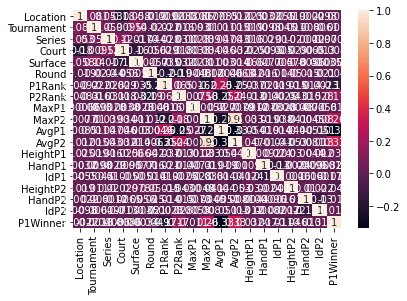

In [254]:
#Correlation matrix
corrMatrix2=normalized_df_new_features.corr()
print(corrMatrix2)
sn.heatmap(corrMatrix2, annot=True)
plt.show() 

### Model with news features

In [255]:
X2=normalized_df_new_features.drop(["P1Winner"],axis=1)
y2=normalized_df_new_features["P1Winner"]

#knn=neighbors.KNeighborsClassifier(n_neighbors=25,weights='uniform')
model = svm.SVC(gamma="auto",kernel='linear')

X_train2,X_test2,y_train2,y_test2 = train_test_split(X2, y2, test_size=0.2)

model.fit(X_train2,y_train2)

prediction2=model.predict(X_test2)

accuracy2 = metrics.classification_report(y_test2,prediction2,target_names=['Player1Lost','Player1Won'])

print("prediction",prediction2)
print("accuracy: ",accuracy2)

SVC(gamma='auto', kernel='linear')

prediction [1 1 1 ... 0 1 1]
accuracy:                precision    recall  f1-score   support

 Player1Lost       0.77      0.55      0.64      4889
  Player1Won       0.64      0.83      0.72      4715

    accuracy                           0.69      9604
   macro avg       0.70      0.69      0.68      9604
weighted avg       0.70      0.69      0.68      9604



## Test Model


In [256]:
col_df=pd.DataFrame(columns=list_col)
df_model_test=pd.read_excel('2021.xlsx')
df_model_test= pd.concat([col_df,df_model_test],ignore_index=True)
df_model_test.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Basilashvili N.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.67,2.56,1.56,2.42
1,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Celikbilek A.,...,NaN,NaN,NaN,NaN,NaN,NaN,2.70,1.55,2.57,1.50
2,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Ruusuvuori E.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.63,3.03,1.52,2.53
3,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Bublik A.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.87,2.30,1.72,2.11
4,1,Antalya,Antalya Open,2021-01-07,ATP250,Indoor,Hard,1st Round,3,Goffin D.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.50,3.00,1.44,2.78


In [257]:
df_model_test=CleanData(df_model_test)

verif=df_model_test.copy()

df_model_test.iloc[:,:-1]=df_model_test.apply(lambda x: (x-x.mean())/x.std() )

In [258]:
X3=df_model_test.drop(["P1Winner"],axis=1)
y3=df_model_test["P1Winner"]


prediction3=model.predict(X3)

accuracy3 = metrics.classification_report(y3,prediction3,target_names=['Player1Lost','Player1Won'])

print("prediction",prediction3)
print("accuracy: ",accuracy3)

prediction [0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1
 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1
 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0
 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1
 1 1]
accuracy:                precision    recall  f1-score   support

 Player1Lost       0.74      0.54      0.62       168
  Player1Won       0.64      0.81      0.71       167

    accuracy                           0.67       335
   macro avg       0.69      0.68      0.67       335
weighted avg       0.69  

In [259]:
verif=verif[["P1Rank","P2Rank","MaxP1","MaxP2","AvgP1","AvgP2","P1Winner"]]
verif["predict"]=prediction3


We want to check if the model doesn't predict the player with the lowest betting average

In [260]:
verif['MinOddP1']=verif.apply(lambda x: 1 if (x['AvgP1']<x['AvgP2'])==x['predict'] else 0,axis=1)
verif.head()

,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,P1Winner,predict,MinOddP1
0,267.0,32.0,2.56,1.67,2.42,1.56,0,0,1
2,67.0,72.0,3.03,1.63,2.53,1.52,0,1,0
3,39.0,76.0,1.87,2.30,1.72,2.11,1,1,1
4,83.0,13.0,3.00,1.50,2.78,1.44,0,0,1
5,42.0,61.0,1.50,2.85,1.45,2.71,0,1,1


In [261]:
verif['MinOddP1'].value_counts()

1    270
0     65
Name: MinOddP1, dtype: int64

It confirmed our fears. The model chose the player with the lower average 95% of the time

## Neural Network Model

In [262]:
inputs=X2.copy()
outputs=y2.copy()

In [263]:
#Build the model
def model_arch():
    list_loss={}
    for i in range(1,inputs.shape[1]+1):
        for j in range(0,inputs.shape[1]+1):
            Ml_model=tf.keras.Sequential([
                tf.keras.layers.Dense(i,input_dim=inputs.shape[1],activation="relu"),
                tf.keras.layers.Dense(j,activation="relu"),
                tf.keras.layers.Dense(1,activation="sigmoid"),
            ])

            #Compile the model

            Ml_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            #Train the model

            history=Ml_model.fit(inputs,outputs,epochs=25, batch_size=128,verbose=0,validation_split=0.2)

            list_loss[str(i)+'/'+str(j)]=history.history['loss'][-1]
    return list_loss

In [264]:
loss=model_arch()

KeyboardInterrupt: 

In [ ]:

sorted_d = {k: v for k, v in sorted(loss.items(), key=lambda x: x[1])}

print(min(loss, key=loss.get))
print(sorted_d)

In [ ]:
plt.plot(list(loss.keys()),list(loss.values()))
plt.xticks(list(loss.keys()))
plt.ylabel ('Loss')
plt.xlabel ('Number of nodes')
plt.show()

In [503]:
df_test.shape

(47768, 14)

In [495]:

df_test[df_test["Tournament"]=='Grand Prix de Lyon']

,Location,Tournament,Series,Court,Surface,Round,Winner,Loser,WRank,LRank,MaxW,MaxL,AvgW,AvgL
2590,Lyon,Grand Prix de Lyon,International,Indoor,Carpet,1st Round,Arthurs W.,Vicente F.,50.0,58.0,1.40,3.35,1.34,3.01
2591,Lyon,Grand Prix de Lyon,International,Indoor,Carpet,1st Round,Bjorkman J.,Gambill J.M.,46.0,43.0,2.10,1.80,1.95,1.72
2592,Lyon,Grand Prix de Lyon,International,Indoor,Carpet,1st Round,Clement A.,Benneteau J.,42.0,231.0,1.27,3.60,1.24,3.50
2593,Lyon,Grand Prix de Lyon,International,Indoor,Carpet,1st Round,Escude N.,Sanguinetti D.,41.0,44.0,1.36,3.25,1.32,3.04
2595,Lyon,Grand Prix de Lyon,International,Indoor,Carpet,1st Round,Grosjean S.,Pioline C.,8.0,124.0,1.40,3.08,1.33,2.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22463,Lyon,Grand Prix de Lyon,ATP250,Indoor,Hard,Quarterfinals,Simon G.,Benneteau J.,12.0,51.0,1.29,3.80,1.26,3.60
22464,Lyon,Grand Prix de Lyon,ATP250,Indoor,Hard,Quarterfinals,Clement A.,Tsonga J.W.,119.0,8.0,7.00,1.13,6.25,1.11
22465,Lyon,Grand Prix de Lyon,ATP250,Indoor,Hard,Semifinals,Ljubicic I.,Clement A.,29.0,119.0,1.35,3.25,1.34,3.18
22466,Lyon,Grand Prix de Lyon,ATP250,Indoor,Hard,Semifinals,Llodra M.,Simon G.,107.0,12.0,3.20,1.40,3.05,1.36


In [497]:
#International Gold=ATP500
#Masters Cup & Masters = ATP Finals

v=dict(df_test["Location"].value_counts())
print(v)

{'Paris': 3158, 'New York': 2396, 'London': 2378, 'Melbourne': 2282, 'Miami': 1624, 'Indian Wells': 1589, 'Rome': 1042, 'Monte Carlo': 989, 'Cincinnati': 989, 'Madrid': 894, 'Barcelona': 888, 'Hamburg': 833, 'Queens Club': 821, 'Washington': 775, 'Shanghai': 708, 'Tokyo': 648, 'Kitzbuhel': 590, 'Rotterdam': 561, 'Stuttgart': 559, 'Acapulco': 559, 'Doha': 555, 'Delray Beach': 550, 'Buenos Aires': 537, 'Basel': 529, 'Dubai ': 528, 'Houston': 527, 'Halle': 517, 'Vienna': 516, 'Newport': 515, 'Marseille': 515, 'St. Petersburg': 503, "'s-Hertogenbosch": 501, 'Gstaad': 500, 'Munich': 497, 'Stockholm': 494, 'Toronto': 493, 'Bastad': 493, 'Auckland': 492, 'Moscow': 491, 'Montreal': 490, 'Umag': 486, 'Sydney': 471, 'Beijing': 468, 'Metz': 461, 'Memphis': 457, 'Chennai': 439, 'Bucharest': 422, 'Winston-Salem': 403, 'Casablanca': 388, 'Valencia': 373, 'San Jose': 349, 'Indianapolis': 322, 'Lyon': 320, 'Brisbane': 306, 'Los Angeles': 305, 'Bangkok': 301, 'Nottingham': 298, 'Vina del Mar': 293, 'Za

In [731]:
z=inputs.copy()
z=z.drop(['Tournament','Round'],axis=1)
#z=z.drop(['IdP1','IdP2'],axis=1)


Ml_model=tf.keras.Sequential([
    tf.keras.layers.Dense(16,input_dim=z.shape[1],activation="relu"),
    #tf.keras.layers.Dense(12,activation="relu"),
    tf.keras.layers.Dense(8,activation="relu"),
    #tf.keras.layers.Dense(4,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid"),
])

#Compile the model

Ml_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train the model

history=Ml_model.fit(z,outputs,epochs=200, batch_size=250,verbose=0)

In [732]:
ML_prediction = Ml_model.predict_classes(X3.drop(['Tournament','Round'],axis=1))
#ML_prediction = Ml_model.predict_classes(X3)
ML_acc = metrics.classification_report(y3,ML_prediction)
print(ML_acc)

              precision    recall  f1-score   support

           0       0.69      0.54      0.61       168
           1       0.62      0.75      0.68       167

    accuracy                           0.65       335
   macro avg       0.66      0.65      0.64       335
weighted avg       0.66      0.65      0.64       335



/Users/pierremecchia/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [733]:
verif=verif[["P1Rank","P2Rank","MaxP1","MaxP2","AvgP1","AvgP2","P1Winner"]]
verif["predict"]=ML_prediction
verif['MinOddP1']=verif.apply(lambda x: 1 if (x['AvgP1']<x['AvgP2'])==x['predict'] else 0,axis=1)
verif.head()

,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,P1Winner,predict,MinOddP1
0,267.0,32.0,2.56,1.67,2.42,1.56,0,0,1
2,67.0,72.0,3.03,1.63,2.53,1.52,0,1,0
3,39.0,76.0,1.87,2.30,1.72,2.11,1,1,1
4,83.0,13.0,3.00,1.50,2.78,1.44,0,0,1
5,42.0,61.0,1.50,2.85,1.45,2.71,0,1,1


In [734]:
verif['MinOddP1'].value_counts()

1    279
0     56
Name: MinOddP1, dtype: int64

In [735]:
verif['P1min']=verif.apply(lambda x: 1 if (x['AvgP1']<x['AvgP2'])==x['P1Winner'] else 0,axis=1)
verif['P1min'].value_counts()

1    227
0    108
Name: P1min, dtype: int64